# impedance.py で　等価回路の定数を予測　
Library impedance.py 

# File読み込み　
Keysight のCSVファイルを読み込んで　Impedance.py でわかる形に変換

C:\Users\tom2r\AppData\Local\Temp\ipykernel_16884\1037209264.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filename,skiprows=4,skipfooter=1)


<Figure size 640x480 with 0 Axes>

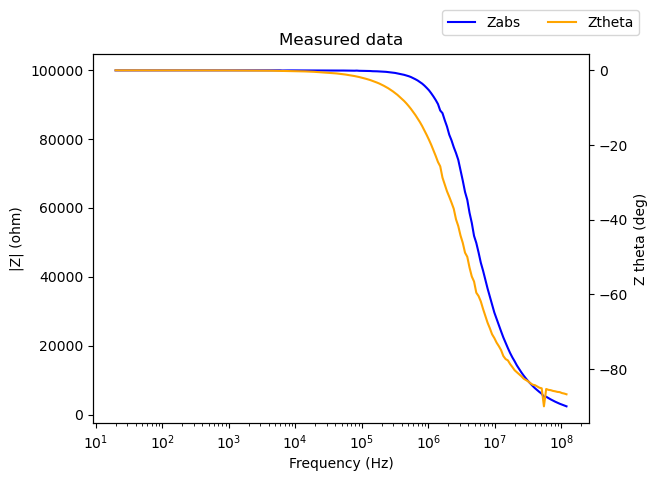

In [2]:
import numpy as np
import pandas as pd

filename='data2/100K OHM.CSV'
with open(filename) as f:
    df = pd.read_csv(filename,skiprows=4,skipfooter=1)

aZt = df.values
freq_array = np.array(aZt[:,0])
Zabs_array = np.array(aZt[:,1])
Theta_array = np.array(aZt[:,2])

#-------------------
import matplotlib.pyplot as plt
fig = plt.figure()

fig, ax1 = plt.subplots()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('|Z| (ohm)')
ax2 = ax1.twinx()
ax2.set_ylabel('Z theta (deg)')
ax1.plot(freq_array,Zabs_array,color='blue',label="Zabs")
ax2.plot(freq_array,Theta_array,color='orange',label="Ztheta")
fig.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1,ncol=2)
plt.title('Measured data')
plt.xscale('log')
plt.show()

#-------------------
import cmath
import math
# |Z|と偏角のデータから、実部・虚部に変換する
Zcomp_array = [cmath.rect(Zabs, theta*math.pi/180.0) for Zabs, theta in zip(Zabs_array, Theta_array)]
Zcomp_array=np.array(Zcomp_array)
from impedance import preprocessing
# 第 1 象限にインピーダンス データのみを保持する
frequencies, Z = preprocessing.ignoreBelowX(freq_array, Zcomp_array)


再変換しても元のデータと同じかテスト

<Figure size 640x480 with 0 Axes>

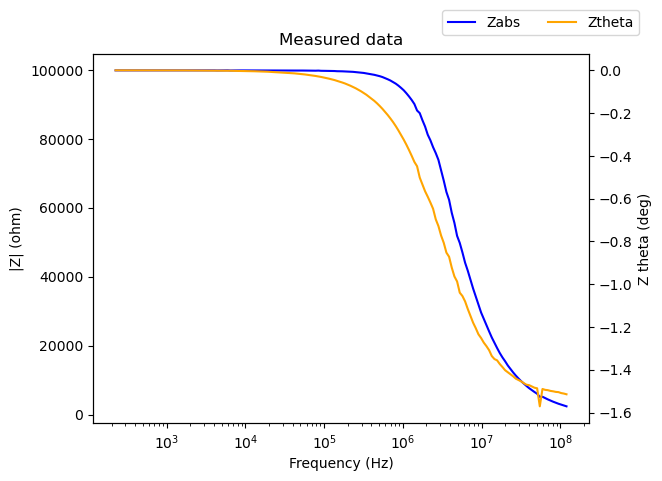

In [4]:
fig = plt.figure()

fig, ax1 = plt.subplots()
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('|Z| (ohm)')
ax2 = ax1.twinx()
ax2.set_ylabel('Z theta (rad)')
ax1.plot(frequencies,abs(Z),color='blue',label="Zabs")
ax2.plot(frequencies,np.angle(Z),color='orange',label="Ztheta")
fig.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1,ncol=2)
plt.title('Measured data')
plt.xscale('log')
plt.show()

# モデルの回路選択し、回路定数を予測
注意　
- initial_guess （初期値）の値により、予測値がかなり異なる。
- 回路構成　 "-" は直列　p( , ) で並列


In [5]:
from impedance.models.circuits import CustomCircuit

initial_guess = [100000, 1E-10,1E-12]
circuit = CustomCircuit('p(R0-L0,C0)', initial_guess=initial_guess)

#circuit.fit(frequencies, Z,global_opt=True)
circuit.fit(frequencies, Z)

print(circuit)


Circuit string: p(R0-L0,C0)
Fit: True

Initial guesses:
     R0 = 1.00e+05 [Ohm]
     L0 = 1.00e-10 [H]
     C0 = 1.00e-12 [F]

Fit parameters:
     R0 = 1.00e+05  (+/- 6.98e-08) [Ohm]
     L0 = 5.54e-02  (+/- 2.88e-02) [H]
     C0 = 2.14e-11  (+/- 6.79e-10) [F]



予測値とデータを比較する。Bode と Nyquistで表示

In [11]:
Z_fit = circuit.predict(frequencies)
circuit.plot(f_data=frequencies, Z_data=Z)

c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\altair\vegalite\v5\api.py:362: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.HConcatChart(...)

ベクトルの差の自乗平均を計算（Fitting 予測の精度を評価するため）　

In [12]:
# RMSE 
from impedance.models.circuits.fitting import rmse

model_rmse = rmse(Z, Z_fit)
print(model_rmse)

51252.728120319065


# おまけ　電池のモデルをいろいろあてはめてみる
## Randlesモデル　RandlesCPEモデル　など

c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\impedance\models\circuits\elements.py:170: RuntimeWarning: overflow encountered in tanh
  Z = Z0 / (np.sqrt(1j * omega * tau) * np.tanh(np.sqrt(1j * omega * tau)))


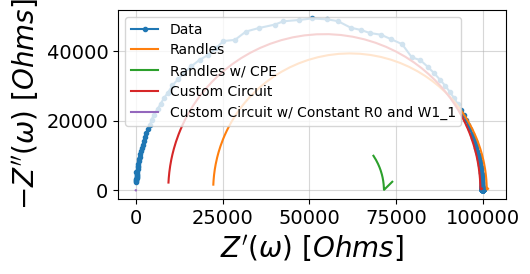


Name: Randles
Circuit string: R0-p(R1-Wo1,C1)
Fit: True

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
  Wo1_0 = 1.00e-03 [Ohm]
  Wo1_1 = 2.00e+02 [sec]
     C1 = 1.00e-01 [F]

Fit parameters:
     R0 = 2.23e+04  (+/- 1.07e+03) [Ohm]
     R1 = 7.88e+04  (+/- 1.16e+02) [Ohm]
  Wo1_0 = 9.23e+05  (+/- 3.41e-02) [Ohm]
  Wo1_1 = 1.94e+03  (+/- 8.14e+00) [sec]
     C1 = 8.37e-13  (+/- 2.29e-10) [F]


Name: Randles w/ CPE
Circuit string: R0-p(R1-Wo1,CPE1)
Fit: True

Initial guesses:
     R0 = 1.00e-02 [Ohm]
     R1 = 5.00e-03 [Ohm]
  Wo1_0 = 1.00e-03 [Ohm]
  Wo1_1 = 2.00e+02 [sec]
  CPE1_0 = 1.00e-01 [Ohm^-1 sec^a]
  CPE1_1 = 9.00e-01 []

Fit parameters:
     R0 = 3.58e+04  (+/- 2.63e-04) [Ohm]
     R1 = 3.57e+04  (+/- 2.63e-04) [Ohm]
  Wo1_0 = 7.75e+04  (+/- 1.99e-05) [Ohm]
  Wo1_1 = 3.66e-01  (+/- 2.11e+00) [sec]
  CPE1_0 = 1.14e-14  (+/- 1.07e-09) [Ohm^-1 sec^a]
  CPE1_1 = 9.99e-01  (+/- 5.82e-02) []


Circuit string: R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1
Fit: True

Initial 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from impedance.visualization import plot_nyquist
from impedance.models.circuits import Randles, CustomCircuit

randles = Randles(initial_guess=[.01, .005, .001, 200, .1])
randlesCPE = Randles(initial_guess=[.01, .005, .001, 200, .1, .9], CPE=True)
customCircuit = CustomCircuit(initial_guess=[.01, .005, .1, .005, .1, .001, 200],
                              circuit='R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1')
customConstantCircuit = CustomCircuit(initial_guess=[None, .005, .1, .005, .1, .001, None],
                                      constants={'R_0': 0.02, 'Wo_1_1': 200},
                                      circuit='R_0-p(R_1,C_1)-p(R_2,C_2)-Wo_1')
randles.fit(frequencies, Z)
randlesCPE.fit(frequencies, Z)
customCircuit.fit(frequencies, Z)
customConstantCircuit.fit(frequencies, Z)

randles_fit = randles.predict(frequencies)
randlesCPE_fit = randlesCPE.predict(frequencies)
customCircuit_fit = customCircuit.predict(frequencies)
customConstantCircuit_fit = customConstantCircuit.predict(frequencies)

fig, ax = plt.subplots(figsize=(5,5))

plot_nyquist(Z, ax=ax)
plot_nyquist(randles_fit, fmt='-', ax=ax)
plot_nyquist(randlesCPE_fit, fmt='-', ax=ax)
plot_nyquist(customCircuit_fit, fmt='-', ax=ax)
plot_nyquist(customConstantCircuit_fit, fmt='-', ax=ax)

ax.legend(['Data', 'Randles', 'Randles w/ CPE', 'Custom Circuit', 'Custom Circuit w/ Constant R0 and W1_1'])
plt.show()
print(randles)
print(randlesCPE)
print(customCircuit)
print(customConstantCircuit)

In [14]:
randlesCPE.plot(f_data=frequencies, Z_data=Z)

c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\impedance\models\circuits\elements.py:170: RuntimeWarning: overflow encountered in tanh
  Z = Z0 / (np.sqrt(1j * omega * tau) * np.tanh(np.sqrt(1j * omega * tau)))
c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\altair\vegalite\v5\api.py:362: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\Users\tom2r\.conda\envs\impedance-analysis\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.HConcatChart(...)